# Order and Online customer behavior using RFM Analysis

    OBJECTIVE: To develop a classification model by formulating calculated fields by analyzing and transforming customers 
    online behavior and conversion data (orders) to useful metrics. 

    These calculated fields are the Recency - When was the last time the customer bought a product? Frequency - How many 
    times did the customer visit the website/application? and Monetary - What is the average spending of the customer? 

    On the basis of these metrics, I will rate those customers from 1 to 3 for the respective fields. Using these metrics 
    I will identify the various types of customers and their personas. Customer personas can be utilized for personalized 
    target marketing and data-driven strategies. Aforementioned will provide the company insights on how to retain 
    highly valued customers or provide insights on how to configure the accessibility and awareness strategies for less 
    engaging customers. Later on, we can perform A/B tests to validate our strategies. 

    Most of our revenue is generated from our existing customer base. It is less expensive to retain an existing customer 
    than acquiring a new one.

In [402]:
# All basic imports
import numpy as np
import pandas as pd
import os
from datetime import datetime
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12,8]

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

import warnings
warnings.filterwarnings('ignore')

In [336]:
# Read Data
onlineData = pd.read_csv("online.csv")
orderData = pd.read_csv("order.csv")

-----

# Exploration, Understanding of the data sets, and Data Cleaning

In [337]:
onlineData.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [338]:
orderData.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


In [351]:
print("Order Data has "+ str(orderData.shape[0])+" rows and "+str(orderData.shape[1])+" columns")
print("Online Data has "+ str(onlineData.shape[0])+" rows and "+str(onlineData.shape[1])+" columns")

Order Data has 263278 rows and 7 columns
Online Data has 954774 rows and 8 columns


    Visitors ids are the devices used by the respective customer to interact with the website or the mobile application. 
    Session ids are the session keys which identifies the session. If the user does not interact for more than 30 
    mins a new session key is created for that particular visitor id.

In [340]:
print(" There are in total " + str(len(onlineData.custno.unique())) + " unique customers in online data")
print(" There are in total " + str(len(orderData.custno.unique())) + " unique customers in order data")

 There are in total 57584 unique customers in online data
 There are in total 70264 unique customers in order data


In [341]:
# Create a separate columns for data and time

onlineData['date'] = onlineData.dt.apply(lambda x : x[0:10])
onlineData['time'] = onlineData.dt.apply(lambda x : x[11:])

orderData['date'] = orderData.orderdate.apply(lambda x : x[0:10])
orderData['time'] = orderData.orderdate.apply(lambda x : x[11:])

In [342]:
# Dropping the datetimes columns

del orderData['orderdate']
del onlineData['dt']

    There are various instances where an order does not have the session activity info in the online data.
    For instance:

    Custno 1

In [343]:
#Result 1 - Custno 1
onlineData[(onlineData.custno == 1)]

,session,visitor,custno,category,event1,event2,date,time


In [344]:
#Result 2 - Custno 1
orderData[(orderData.custno == 1)]

,custno,ordno,prodcat2,prodcat1,revenue,date,time
4,1,1,NaN,1,8.35,2017-06-12,08:27:59


    Example of an instance which has the online activity information before the order was purchased

    Custno 637

In [345]:
#Result 1 - custno 637
onlineData[(onlineData.custno == 637) & (onlineData.date == "2017-10-04")]

,session,visitor,custno,category,event1,event2,date,time
71874,9,405166,637,2,NaN,3,2017-10-04,13:36:14
135720,9,405166,637,2,NaN,7,2017-10-04,13:07:03


In [346]:
#Result 2 - custno 637
orderData[(orderData.custno == 637) & (orderData.date == "2017-10-04")]

,custno,ordno,prodcat2,prodcat1,revenue,date,time
153499,637,84765,25.0,7,68.48,2017-10-04,02:08:35
166738,637,151367,30.0,3,119.46,2017-10-04,13:47:35


    If you refer the result 2 index 153499, there was no online activity logged before that order. Whereas in 
    result 1 we see that there are two activites logged within 30 mins period having same session id. Later there 
    was a purchase made by the customer on 13:47:35, approximately after 10 mins.

    Therefore, I will be keeping only the records which has the online session data after merging order and online table.

In [347]:
data = pd.merge(onlineData, orderData,  how='outer', left_on=['custno','date'], right_on = ['custno','date'])

In [360]:
# Function to calculate the time difference and check if the online activing and order info wass in same session
def timeDiff(x,y):
    format = '%H:%M:%S'
    return (datetime.strptime(x, format) - datetime.strptime(y, format))

def sameSession(x):
    if(x.seconds < 1800):
        return 1
    else:
        return 0

In [350]:
print("Merged Data has "+ str(data.shape[0])+" rows and "+str(data.shape[1])+" columns")

Merged Data has 1196649 rows and 13 rows


In [352]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y
0,419542.0,140970.0,3840,1.0,NaN,1.0,2016-09-16,05:03:23,NaN,NaN,NaN,NaN,NaN
1,3030130.0,14501.0,70400,1.0,NaN,1.0,2017-11-13,04:58:12,NaN,NaN,NaN,NaN,NaN
2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23
3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23
4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23


     Filtering data having missing values

In [356]:
data = data[data.time_y.notnull()]

In [357]:
data = data[data.time_x.notnull()]

In [358]:
print("Merged Data now has "+ str(data.shape[0])+" rows and "+str(data.shape[1])+" columns")

Merged Data now has 107164 rows and 13 columns


In [359]:
#Calculating the time difference

data['timeDiff'] = data.apply(lambda x: timeDiff(x['time_y'],x['time_x']), axis = 1)

In [361]:
data['sameSession'] = data['timeDiff'].apply(lambda x : sameSession(x))

In [21]:
data.shape

(107164, 15)

In [22]:
data = data[data.sameSession == 1 ]

In [23]:
data['timediff'] = data['timeDiff'].apply(lambda x: x.seconds)

In [362]:
print("Merged Data now has "+ str(data.shape[0])+" rows and "+str(data.shape[1])+" columns")

Merged Data now has 107164 rows and 15 columns


In [363]:
data.head()

,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession
2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23,00:04:45,1
3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23,00:04:45,1
4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23,00:04:45,1
47,419741.0,191480.0,57090,1.0,NaN,1.0,2016-06-30,20:29:29,111234.0,3.0,2.0,119.47,20:09:33,-1 days +23:40:04,0
48,419741.0,191480.0,57090,1.0,NaN,1.0,2016-06-30,20:29:29,111234.0,9.0,3.0,10.38,20:09:33,-1 days +23:40:04,0


In [364]:
#Total no of unique customers now
len(data.custno.unique())

21541

In [365]:
data = data.reset_index()

In [366]:
data.head()

,index,session,visitor,custno,category,event1,event2,date,time_x,ordno,prodcat2,prodcat1,revenue,time_y,timeDiff,sameSession
0,2,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,3.0,2.0,101.00,16:15:23,00:04:45,1
1,3,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,6.0,3.0,81.70,16:15:23,00:04:45,1
2,4,2638740.0,419353.0,21248,1.0,NaN,1.0,2017-05-24,16:10:38,33106.0,9.0,3.0,21.81,16:15:23,00:04:45,1
3,47,419741.0,191480.0,57090,1.0,NaN,1.0,2016-06-30,20:29:29,111234.0,3.0,2.0,119.47,20:09:33,-1 days +23:40:04,0
4,48,419741.0,191480.0,57090,1.0,NaN,1.0,2016-06-30,20:29:29,111234.0,9.0,3.0,10.38,20:09:33,-1 days +23:40:04,0


In [367]:
del data['index']

In [368]:
data.dtypes

session                float64
visitor                float64
custno                   int64
category               float64
event1                 float64
event2                 float64
date                    object
time_x                  object
ordno                  float64
prodcat2               float64
prodcat1               float64
revenue                float64
time_y                  object
timeDiff       timedelta64[ns]
sameSession              int64
dtype: object

In [369]:
data['date'] = pd.to_datetime(data['date'])

In [370]:
data = data.sort_values('session')

### Visualizations to understand the data

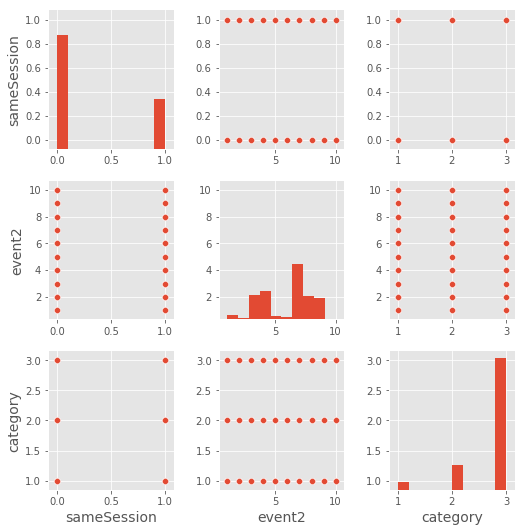

In [421]:
import seaborn as sns
sns.pairplot(data[['sameSession','event2','category']])

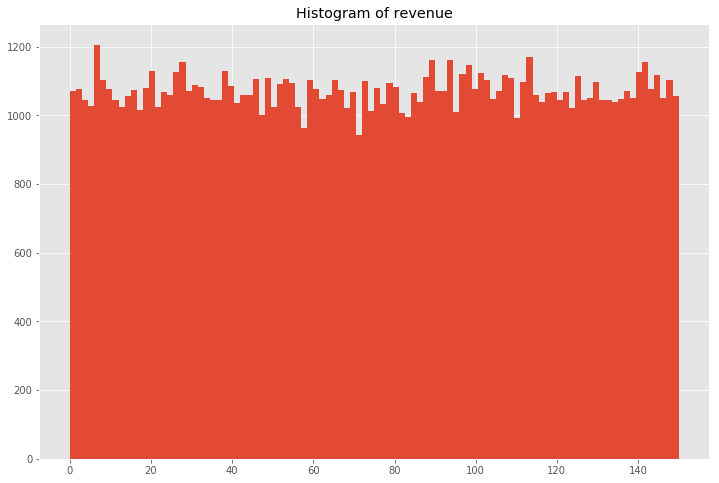

In [403]:
plt.hist(data.revenue, bins= 100)
plt.title('Histogram of revenue')
plt.show()

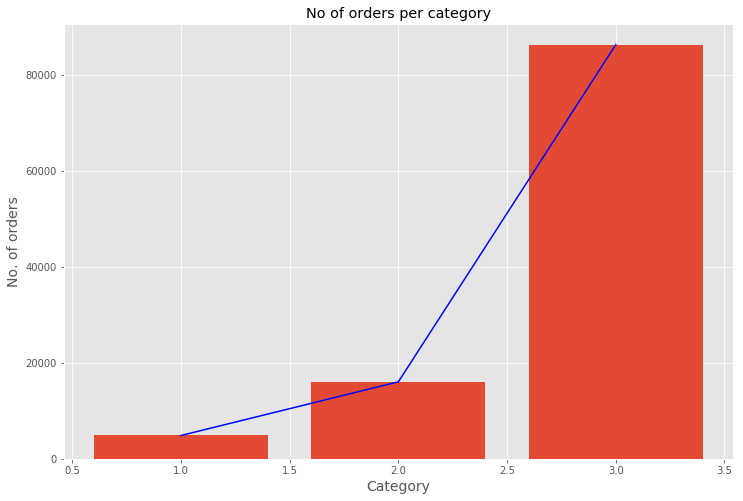

In [404]:
temp = data.groupby(['category']).size()
plt.plot(data.groupby(['category']).size(),color = 'b')
plt.bar(temp.index, temp.values)
plt.title('No of orders per category')
plt.xlabel('Category')
plt.ylabel('No. of orders')
plt.show()

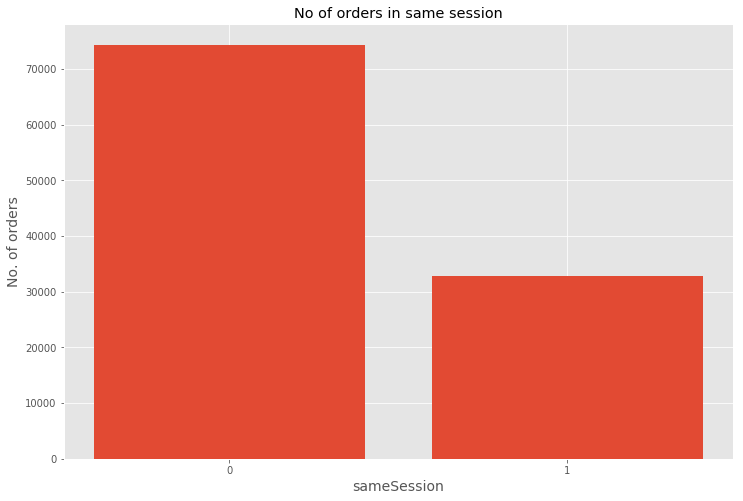

In [415]:
temp = data.groupby(['sameSession']).size()
plt.bar(temp.index, temp.values)
plt.title('No of orders in same session')
plt.xlabel('sameSession')
plt.ylabel('No. of orders')
plt.xticks([0,1])
plt.show()

---

## RFM dataset creation

### Total revenue per session and Total session attended

In [422]:
temp = data.groupby(['session']).sum()

In [423]:
temp = temp.sort_index()

In [424]:
temp.head()

,visitor,custno,category,event1,event2,ordno,prodcat2,prodcat1,revenue,sameSession
session,,,,,,,,,,
9.0,1620664.0,2548,8.0,NaN,20.0,472264.0,110.0,20.0,375.88,1
21.0,383763.0,69508,2.0,NaN,4.0,148458.0,13.0,4.0,105.21,1
32.0,278715.0,4008,2.0,NaN,7.0,81006.0,50.0,7.0,25.40,1
33.0,411422.0,53966,2.0,NaN,9.0,104128.0,169.0,1.0,71.60,0
53.0,469594.0,21449,2.0,NaN,9.0,152095.0,30.0,3.0,11.99,0


In [425]:
behaviorData = temp[['revenue','sameSession']]

In [426]:
behaviorData.head()

,revenue,sameSession
session,,
9.0,375.88,1
21.0,105.21,1
32.0,25.40,1
33.0,71.60,0
53.0,11.99,0


### Add customer id to behavior data

In [427]:
temp = data[['session','custno']]

In [428]:
temp = temp.drop_duplicates()

In [429]:
temp.index = temp.session

In [430]:
temp.head()

,session,custno
session,,
9.0,9.0,637
21.0,21.0,69508
32.0,32.0,4008
33.0,33.0,53966
53.0,53.0,21449


In [431]:
behaviorData['custno'] = temp['custno']

In [432]:
behaviorData.head()

,revenue,sameSession,custno
session,,,
9.0,375.88,1,637
21.0,105.21,1,69508
32.0,25.40,1,4008
33.0,71.60,0,53966
53.0,11.99,0,21449


In [433]:
# Rename Columns
behaviorData.columns = ['revenue','countOfProducts','custno']

#### add date purchased in Behavior data

In [434]:
temp = data[['custno', 'date','session']]

In [435]:
temp = temp.drop_duplicates(['session'])

In [436]:
temp = temp.sort_values(['custno'])

In [437]:
temp.index = temp.session

In [438]:
temp.head()

,custno,date,session
session,,,
2379149.0,7,2016-04-25,2379149.0
3446701.0,8,2017-12-27,3446701.0
2333771.0,8,2017-09-12,2333771.0
3632314.0,8,2016-12-11,3632314.0
3676780.0,8,2016-12-13,3676780.0


In [439]:
behaviorData = behaviorData.sort_values(['custno'])

In [440]:
behaviorData['date'] = temp['date']

In [441]:
behaviorData.head()

,revenue,countOfProducts,custno,date
session,,,,
2379149.0,665.35,0,7,2016-04-25
3446701.0,111.49,0,8,2017-12-27
2333771.0,152.85,0,8,2017-09-12
3632314.0,176.00,1,8,2016-12-11
3676780.0,179.03,0,8,2016-12-13


In [442]:
behaviorData[behaviorData.isnull()].count()

revenue            0
countOfProducts    0
custno             0
date               0
dtype: int64

In [443]:
behaviorData.head()

,revenue,countOfProducts,custno,date
session,,,,
2379149.0,665.35,0,7,2016-04-25
3446701.0,111.49,0,8,2017-12-27
2333771.0,152.85,0,8,2017-09-12
3632314.0,176.00,1,8,2016-12-11
3676780.0,179.03,0,8,2016-12-13


In [444]:
behaviorData = behaviorData.reset_index()

In [445]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
0,2379149.0,665.35,0,7,2016-04-25
1,3446701.0,111.49,0,8,2017-12-27
2,2333771.0,152.85,0,8,2017-09-12
3,3632314.0,176.00,1,8,2016-12-11
4,3676780.0,179.03,0,8,2016-12-13


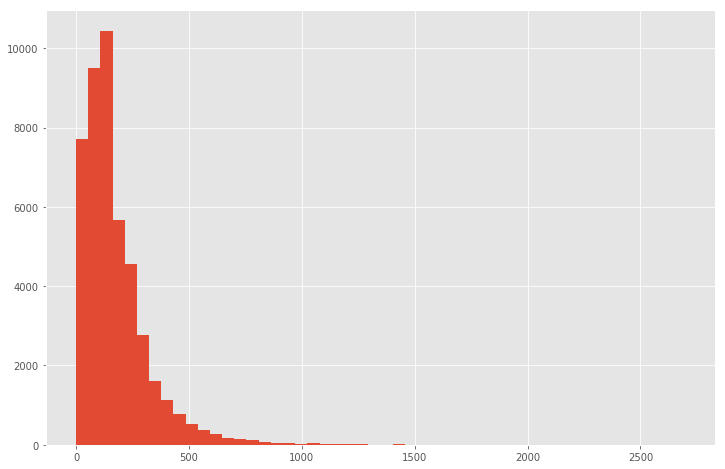

In [446]:
behaviorData.revenue.hist(bins= 50)
plt.show()

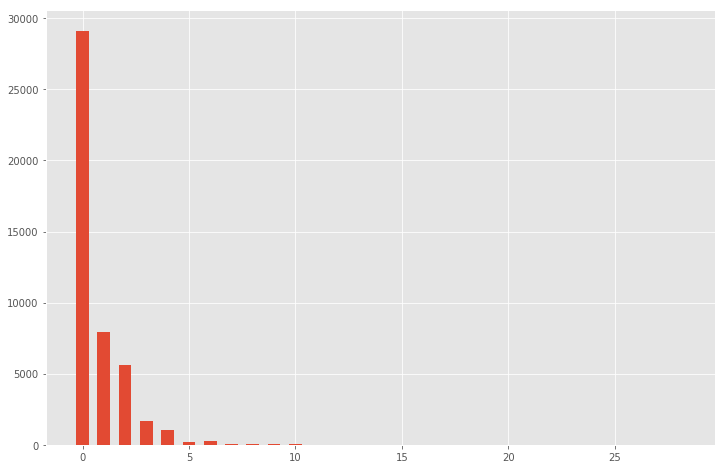

In [447]:
temp = behaviorData.groupby(['countOfProducts']).count()
plt.bar(temp.index, temp.session, width = 0.6)
plt.show()

-----

# Feature engineering and Feature selection

    Objective: To create a new dataset based to RFM metrics
    
    Recency - Rating based on number of days since last purschase
    
    3 -> 0   - 239   days
    2 -> 240 - 479   days
    1 -> 480 - above days
    
    Frequency - No of times the customers attended a session
    
    3 -> 21 - above  Sessions
    2 -> 11 - 20     Sessions
    1 -> 1  - 10     Sessions
    
    Monetary - The average amount of spending per order
    
    3 -> 200 - above Revenue
    2 -> 79  - 199   Revenue
    1 -> 0   - 78    Revenue
    

    Note: It is a batch learning process so we need to calibrate the metrics after a certian time.

In [199]:
RFMData = pd.DataFrame(behaviorData['custno'].unique())

In [200]:
RFMData.head()

,0
0,8
1,9
2,11
3,15
4,17


In [201]:
RFMData.columns = ['custno']

In [202]:
RFMData.index = RFMData.custno

In [203]:
RFMData.head()

,custno
custno,
8,8
9,9
11,11
15,15
17,17


###  Monetary

In [204]:
temp = behaviorData.groupby(['custno']).mean()

In [205]:
temp.head()

,session,revenue,countOfProducts
custno,,,
8,2.220996e+06,207.73500,3.000000
9,2.155525e+06,217.47375,2.500000
11,2.351018e+06,97.67500,1.166667
15,3.478851e+06,68.42000,2.000000
17,8.579700e+05,190.04000,3.250000


In [206]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
session,,,,,
809678.0,809678.0,327.47,5,8,2017-03-29
3632314.0,3632314.0,88.00,1,8,2016-12-11
3189010.0,3189010.0,208.86,4,9,2016-05-20
842759.0,842759.0,809.36,6,9,2016-05-21
3467201.0,3467201.0,129.58,2,9,2017-10-29


In [207]:
RFMData['avgSpending'] = temp['revenue']

In [208]:
RFMData.head()

,custno,avgSpending
custno,,
8,8,207.73500
9,9,217.47375
11,11,97.67500
15,15,68.42000
17,17,190.04000


#### Frequency

In [209]:
temp = behaviorData.groupby(['custno']).count()

In [210]:
temp.head()

,session,revenue,countOfProducts,date
custno,,,,
8,2,2,2,2
9,8,8,8,8
11,6,6,6,6
15,1,1,1,1
17,4,4,4,4


In [211]:
RFMData['frequencyOfPurchase'] = temp['session']

In [212]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase
custno,,,
8,8,207.73500,2
9,9,217.47375,8
11,11,97.67500,6
15,15,68.42000,1
17,17,190.04000,4


### Recency

In [213]:
behaviorData.head()

,session,revenue,countOfProducts,custno,date
session,,,,,
809678.0,809678.0,327.47,5,8,2017-03-29
3632314.0,3632314.0,88.00,1,8,2016-12-11
3189010.0,3189010.0,208.86,4,9,2016-05-20
842759.0,842759.0,809.36,6,9,2016-05-21
3467201.0,3467201.0,129.58,2,9,2017-10-29


In [214]:
def countNoOfDays(date):
    latestDate = max(behaviorData['date'])
    diff = latestDate - date
    return diff.days

In [215]:
temp = behaviorData.groupby(['custno']).max()

In [216]:
behaviorData.index = behaviorData.session

In [217]:
RFMData['lastPurchase'] = temp['date'].apply(lambda x: countNoOfDays(x))

In [218]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase,lastPurchase
custno,,,,
8,8,207.73500,2,277
9,9,217.47375,8,63
11,11,97.67500,6,32
15,15,68.42000,1,617
17,17,190.04000,4,20


### Customer persona

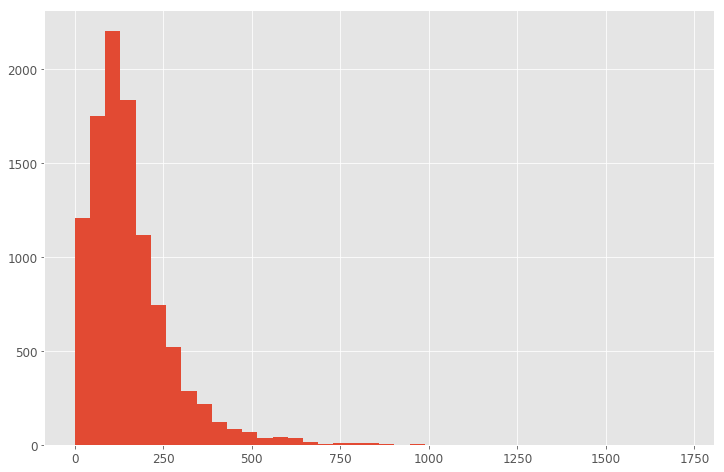

In [219]:
RFMData.avgSpending.hist(bins= 40)
plt.show()

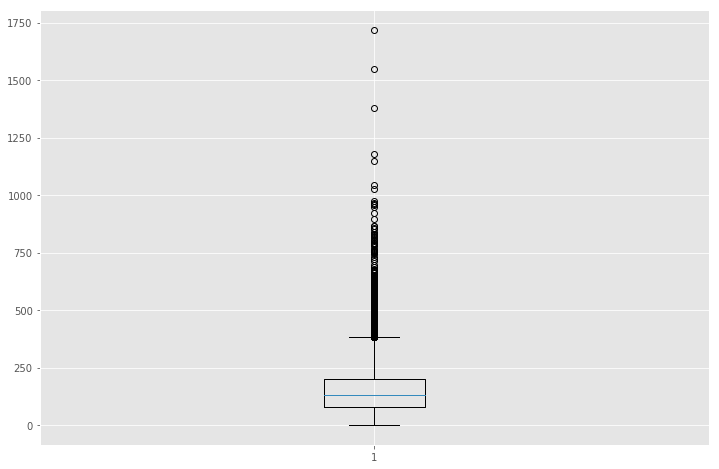

count    10323.00000
mean       154.38965
std        119.63580
min          0.03000
25%         78.67000
50%        129.06500
75%        199.88500
max       1718.97000
Name: avgSpending, dtype: float64

In [448]:
plt.boxplot(RFMData.avgSpending)
plt.show()
RFMData.avgSpending.describe()

In [222]:
def recency(x):
    if(x >= 0 and x < 240):
        return 3
    elif(x >= 240 and x < 480):
        return 2
    else:
        return 1

In [223]:
def frequency(x):
    if(x >= 0 and x <= 10):
        return 1
    elif(x >= 11 and x < 20):
        return 2
    else:
        return 3

In [224]:
def monetary(x):
    if(x >= 0 and x < 78):
        return 1
    elif(x >= 78 and x < 199):
        return 2
    else:
        return 3

In [225]:
RFMData['recency'] = RFMData.lastPurchase.apply(lambda x : recency(x))

In [226]:
RFMData['frequency'] = RFMData.frequencyOfPurchase.apply(lambda x : frequency(x))

In [227]:
RFMData['monetary'] = RFMData.avgSpending.apply(lambda x: monetary(x))

In [228]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase,lastPurchase,recency,frequency,monetary
custno,,,,,,,
8,8,207.73500,2,277,2,1,3
9,9,217.47375,8,63,3,1,3
11,11,97.67500,6,32,3,1,2
15,15,68.42000,1,617,1,1,1
17,17,190.04000,4,20,3,1,2


In [229]:
temp = RFMData[['recency','monetary','frequency']]

In [230]:
temp.drop_duplicates()

,recency,monetary,frequency
custno,,,
8,2,3,1
9,3,3,1
11,3,2,1
15,1,1,1
18,1,3,1
22,2,2,1
25,1,2,1
28,2,1,1
39,3,2,2


In [231]:
RFMData.shape

(10323, 7)

In [232]:
del RFMData['custno']

In [233]:
RFMData = RFMData.reset_index()

In [234]:
RFMData['type'] = 0
for i in RFMData.index:
     RFMData['type'][i] = str(str(RFMData['recency'][i])+str(RFMData['monetary'][i])+str(RFMData['frequency'][i])) 

In [235]:
len(RFMData.type.unique())

15

In [236]:
RFMData.head()

,custno,avgSpending,frequencyOfPurchase,lastPurchase,recency,frequency,monetary,type
0,8,207.73500,2,277,2,1,3,231
1,9,217.47375,8,63,3,1,3,331
2,11,97.67500,6,32,3,1,2,321
3,15,68.42000,1,617,1,1,1,111
4,17,190.04000,4,20,3,1,2,321


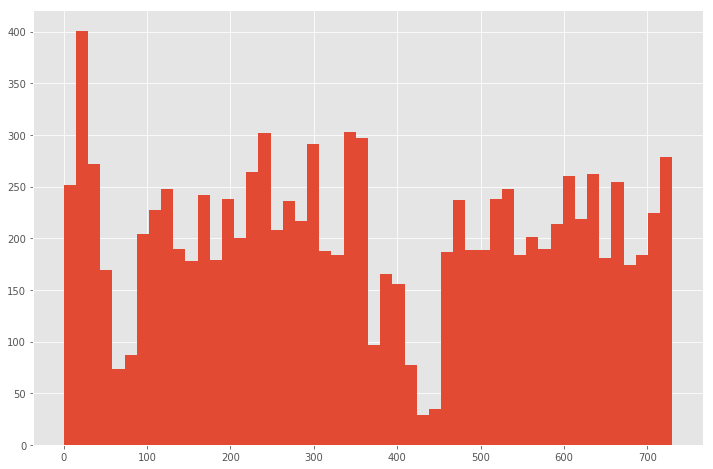

In [456]:
# Trimodal histogram indicating 3 classes
plt.hist(RFMData.lastPurchase,bins= 50)
plt.show()

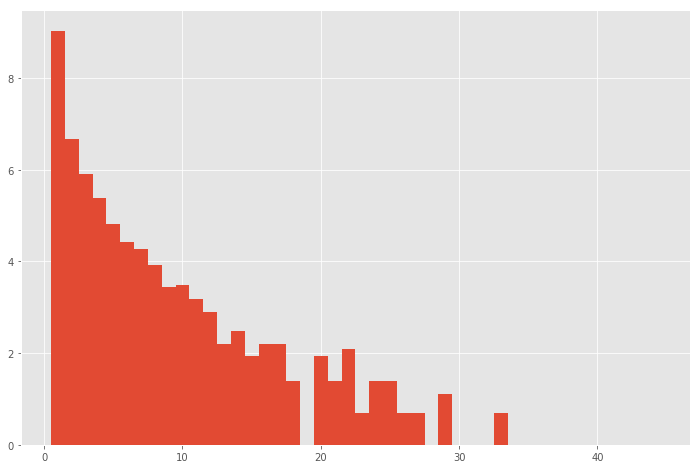

In [457]:
# Extremely right skewed, as usually customer buy once or twice, our goal is to increase that number by target marketing
temp = RFMData.groupby(['frequencyOfPurchase']).count()
plt.bar(temp.index, np.log(temp.type), width = 1)
plt.show()

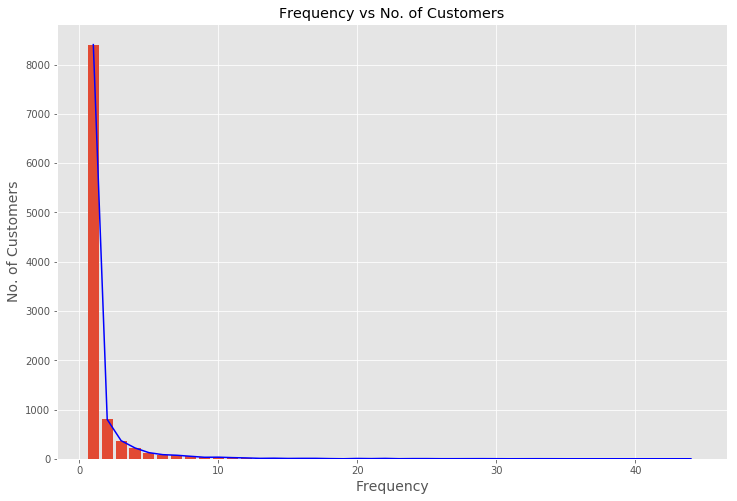

In [461]:
temp = RFMData.groupby(['frequencyOfPurchase']).size()
plt.plot(RFMData.groupby(['frequencyOfPurchase']).size(),color = 'b')
plt.bar(temp.index, temp.values)
plt.title('Frequency vs No. of Customers')
plt.xlabel('Frequency')
plt.ylabel('No. of Customers')
plt.show()

    Very high correlation with lastPurchase

In [459]:

RFMData[['avgSpending','frequencyOfPurchase','lastPurchase','type']].corr()

,avgSpending,frequencyOfPurchase,lastPurchase,type
avgSpending,1.000000,-0.055377,-0.006588,0.067411
frequencyOfPurchase,-0.055377,1.000000,-0.313718,0.272742
lastPurchase,-0.006588,-0.313718,1.000000,-0.940238
type,0.067411,0.272742,-0.940238,1.000000


In [240]:
sc = StandardScaler()

In [241]:
sc.fit(RFMData)

StandardScaler(copy=True, with_mean=True, with_std=True)

## Model design and Sampling


In [168]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [170]:
X = RFMData[['avgSpending', 'frequencyOfPurchase','lastPurchase']]

In [171]:
y = RFMData['type']

In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state = 0)

In [244]:
from sklearn.linear_model import SGDClassifier

In [245]:
sgdCLF = SGDClassifier()

In [246]:
sgdCLF.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [247]:
y_pred = sgdCLF.predict(X_test)

In [249]:
from sklearn.metrics import accuracy_score, f1_score

In [250]:
accuracy_score(y_pred, y_test)

0.3280594123345173

In [253]:
f1_score(y_pred, y_test, average='weighted')

0.4173913886612494

In [294]:
from sklearn.metrics import confusion_matrix

In [292]:
cm  = confusion_matrix(y_pred,y_test)

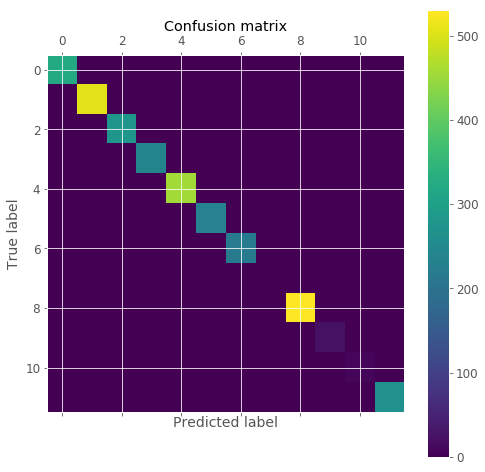

In [293]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [256]:
from sklearn.neighbors import KNeighborsClassifier

In [309]:
knnCLF = KNeighborsClassifier(n_neighbors= 15)

In [310]:
knnCLF.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [311]:
y_pred = knnCLF.predict(X_test)

In [312]:
accuracy_score(y_pred,y_test)

0.9622215046819502

In [313]:
confusion_matrix(y_pred,y_test)

array([[317,   5,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6, 495,   3,   0,   3,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2, 270,   0,   0,   5,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 222,   2,   0,   1,   0,   0,   0,   0,   0],
       [  0,   3,   0,   8, 443,   0,   0,   0,   1,   0,   0,   0],
       [  0,   1,   6,   0,   7, 229,   0,   0,   0,   0,   0,   6],
       [  0,   0,   0,   8,   0,   0, 217,   2,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0,   3,   0, 526,  25,   7,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0, 260]],
      dtype=int64)

In [282]:
from sklearn.ensemble import RandomForestClassifier

In [283]:
RF_clf = RandomForestClassifier()

In [285]:
RF_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [287]:
y_pred = RF_clf.predict(X_test)

In [288]:
accuracy_score(y_pred,y_test)

0.999354213755247

In [295]:
from sklearn.naive_bayes import GaussianNB

In [296]:
NB_clf = GaussianNB()

In [299]:
NB_clf.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [300]:
y_pred = NB_clf.predict(X_test)

In [301]:
accuracy_score(y_pred,y_test)

0.8773006134969326

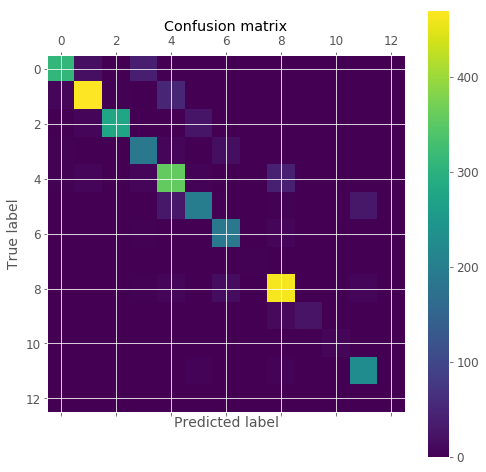

In [304]:
cm = confusion_matrix(y_pred,y_test)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model generation


In [307]:
import pickle
with open('NB_clf.pkl', 'wb') as fid:
    pickle.dump(NB_clf, fid)

## Model evaluation